## This notebook generates the components of Extended Data Figure 4 

in "Entrained debris records regrowth of the Greenland Ice Sheet after the last interglacial" 

---
That figure contains the following components

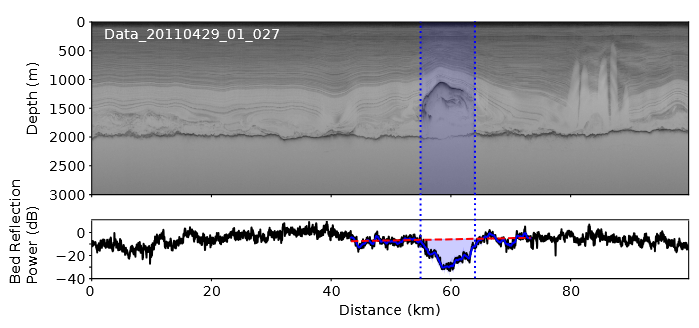


In [1]:
#############################################
### Necessary input statements

######## System untilities
import os
import shutil
import sys
import glob

######## Numerical and plotting tools
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42
import tqdm

import statsmodels.api as sm
import statsmodels.formula.api as smf

######## Any necessary path additions can go here:
sys.path.append('/mnt/data01/Code/opr_python/')

######## OPR library tools
import opr_python as ndh

data_root = '/mnt/data02/Dataverse_TestData/EntrainedDebris/'
generate_pdfs_flag = 0

/mnt/data01/Code/opr_python/opr_python/spreading_correction_image.py:68: RuntimeWarning: divide by zero encountered in log10
  power_corrected_radarim = 10*np.log10(radar_image)-spreading_losses+attenuation_losses


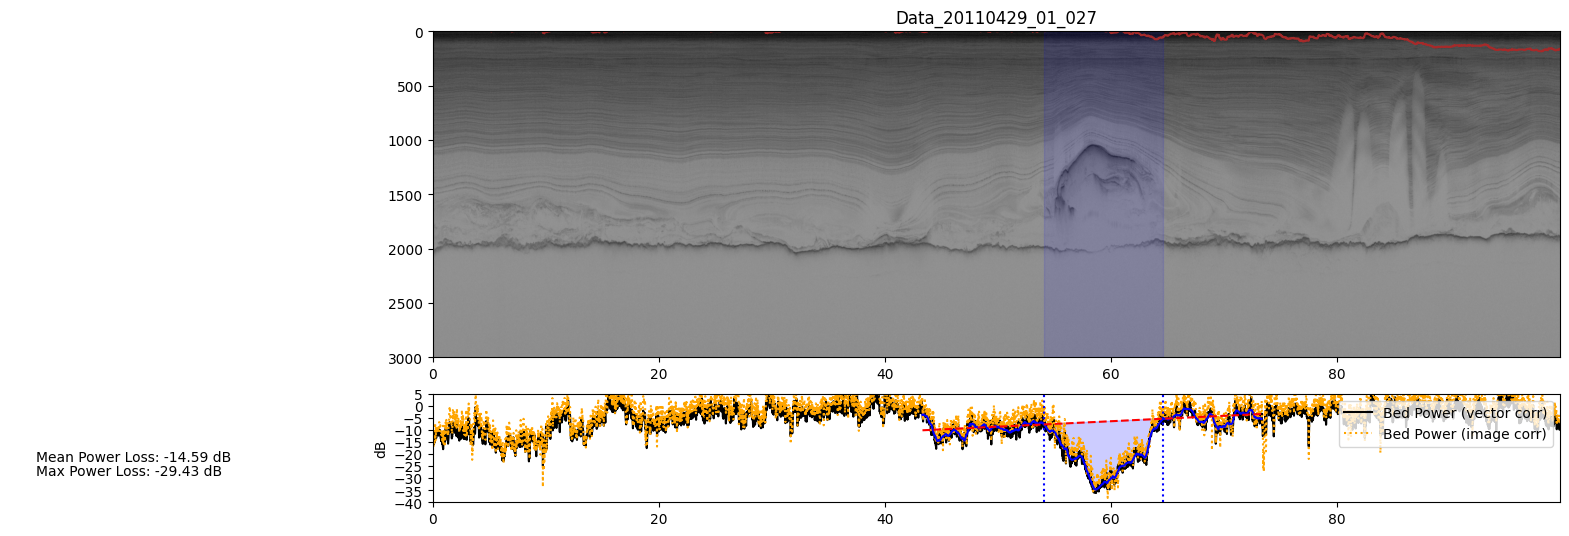

In [5]:
#######################################
### Here we actually extract the power
#######################################


target_files = ['Data_20110429_01_026','Data_20110429_01_027']
averaging_halfwindow = 5
feature_location = np.array([[ -139357.68700313, -1154292.45679988]])

file_list = []
for tf in target_files:
    file_list.append(data_root+tf+'.mat')

####################### Load the radar data and crop if there are strange distance jumps
radar_data, depth_data = ndh.radar_load(file_list,plot_flag=0,elevation1_or_depth2=2)

crop_info = ndh.distance_separator(radar_data['distance'],0,100,1)
crop_inds = np.array(ndh.minmax(crop_info[0][:,2])).astype(int)
radar_data, depth_data = ndh.crop_radardata(radar_data,crop_inds[0],crop_inds[1],depth_data)

xy = ndh.polarstereo_fwd(radar_data['Latitude'],radar_data['Longitude'])
trace_ind = ndh.find_nearest_xy(np.stack([xy['x'],xy['y']]).T,feature_location)


####################### identify the bed indecies
bed_index = ndh.find_nearest(radar_data['Time'],radar_data['Bottom'])
bed_index = bed_index['index']

################### Aggregating the bed power information
bed_power_window = []
bed_power_sample = []
for i in np.arange(-1*averaging_halfwindow,averaging_halfwindow):
    if i == 0:
        bed_power_sample.append(10*np.log10(radar_data['Data'][bed_index.astype(int),np.arange(len(bed_index))]))
    bed_power_window.append(radar_data['Data'][bed_index.astype(int)-+i,np.arange(len(bed_index))])
bed_power_window = np.array(bed_power_window)
bed_power_window = 10*np.log10(np.mean(bed_power_window,axis=0))
bed_power_sample = np.array(bed_power_sample)[0]

################### Calculating and applying the bed_power correction
corrections = ndh.spreading_correction(radar_data['Elevation']-depth_data['surface_elev'],radar_data['Bottom'])

spreading_corrected_power_window = bed_power_window-corrections['raytracing']
spreading_corrected_power_sample = bed_power_sample-corrections['raytracing']

#################### Estimating attenuation rate by removing thickness dependent term
p=[0] # Assume attenuation rate of zero
spreading_attenuation_corrected_power_window = spreading_corrected_power_window - p[0]*depth_data['bed_elev']
spreading_attenuation_corrected_power_sample = spreading_corrected_power_sample - p[0]*depth_data['bed_elev']

#################### Here, we do the quantile regression:
# Creating the data set
regression_window = 15000
regression_inds_minmax = ndh.find_nearest(radar_data['distance'],
                                          [radar_data['distance'][trace_ind['index'][0]]-regression_window,
                                           radar_data['distance'][trace_ind['index'][0]]+regression_window])
ri = np.arange(regression_inds_minmax['index'][0],regression_inds_minmax['index'][1])
df = pd.DataFrame({'Distance': radar_data['distance'][ri], 
                   'Power': spreading_attenuation_corrected_power_window[ri]})

power_fits = []
quantile_targets = [0.5,0.7,0.9,0.95]
qtls = ['-','--','-.',':']
for qts in quantile_targets:
    # fit the model
    model = smf.quantreg('Power ~ Distance',
                         df).fit(q=qts)

    # get y values
    power_fit_line = lambda a, b: a + b*radar_data['distance'][ri]
    power_fits.append(power_fit_line(model.params['Intercept'],
               model.params['Distance']))

################### Here we identify the power anomaly based on the 70th percentile regression
################### crossover positions with the smoothed power
dx = np.median(np.diff(radar_data['distance']))
smoothed_power = ndh.smooth_ndh(ndh.interpNaN(spreading_attenuation_corrected_power_window[ri]),int(500/dx))
smoothed_intersections = ndh.crossovers(np.stack([df['Distance'],smoothed_power]).T,
                                        np.stack([df['Distance'],power_fits[1]]).T)

co_i1 = np.where(smoothed_intersections['intersection_ind'][0]-trace_ind['index'][0]+ri[0] < 0)[0][-1]
co_i2 = np.where(smoothed_intersections['intersection_ind'][0]-trace_ind['index'][0]+ri[0] > 0)[0][0]
co_i1_local = smoothed_intersections['intersection_ind'][0][co_i1]
co_i2_local = smoothed_intersections['intersection_ind'][0][co_i2]
co_i1 = smoothed_intersections['intersection_ind'][0][co_i1]+ri[0]
co_i2 = smoothed_intersections['intersection_ind'][0][co_i2]+ri[0]


################### We establish the index range for the structure, and extract the mean power difference
body_highlight_box = ndh.box_from_corners([radar_data['distance'][co_i1],radar_data['distance'][co_i2]],[3000,0])
power_highlight_box = np.stack([np.concatenate([radar_data['distance'][co_i1:co_i2],radar_data['distance'][co_i2:co_i1:-1]]),
                               np.concatenate([power_fits[1][co_i1_local:co_i2_local],
                                               spreading_attenuation_corrected_power_window[co_i2:co_i1:-1]])]).T

################### Here we produce the attenuation corrected image for use in inferring englacial scattering
radar_image = depth_data['new_data']
flight_elev = radar_data['Elevation']-depth_data['surface_elev']
depth_axis = depth_data['depth_axis']
attenuation_val = 0  ### This value doesn't really affect the results
attenuation_type = 1

power_corrected_im = ndh.spreading_correction_image(radar_image,flight_elev,depth_axis,attenuation_val,attenuation_type)
test_imcorrectedpower = power_corrected_im['corrected_im'][(bed_index-depth_data['shift_amount']).astype(int),np.arange(len(bed_index))]

#################### Calculate mean power diminution
power_losses = spreading_attenuation_corrected_power_window[co_i1:co_i2]-power_fits[1][co_i1_local:co_i2_local]
mean_power_loss = np.mean(power_losses)    
max_power_loss = np.min(power_losses)    

########################################################################################################
############### The radar image


fig = plt.figure(figsize=(20,8))
gs = GridSpec(3, 2, width_ratios=[1, 4], height_ratios=[3,1,1])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,1])
ax_text = fig.add_subplot(gs[1,0])

imdata = ax2.imshow(power_corrected_im['corrected_im'],
                extent=[radar_data['distance'][0]/1000,radar_data['distance'][-1]/1000,
                        depth_data['depth_axis'][0],depth_data['depth_axis'][-1]],
                origin='lower',aspect='auto',cmap='gray_r')                
ax2.plot(radar_data['distance']/1000,depth_data['bed_elev'],c='brown')
ax2.fill(body_highlight_box[:,0]/1000,body_highlight_box[:,1],c='blue',alpha=0.1)
ax2.set_ylim([3000,0])
ax2.set_title('%s' % (target_files[1].split('/')[-1].split('.')[0]))
ax2.set_xlim(ndh.minmax(radar_data['distance']/1000))

############### The bed power
ax3.plot(radar_data['distance']/1000,spreading_attenuation_corrected_power_window-power_removal,'-',c='black',label='Bed Power (vector corr)')  
ax3.plot(radar_data['distance']/1000,test_imcorrectedpower-power_removal,':',c='orange',label='Bed Power (image corr)')  
ax3.axvline(radar_data['distance'][co_i1]/1000,ls=':',c='blue')  
ax3.plot(radar_data['distance'][ri]/1000,smoothed_power-power_removal,c='blue')
ax3.axvline(radar_data['distance'][co_i2]/1000,ls=':',c='blue')  
for qt_inds in [1]: #np.arange(len(quantile_targets)):
    ax3.plot(radar_data['distance'][ri]/1000, power_fits[qt_inds]-power_removal, color='red', ls=qtls[qt_inds])
ax3.fill(power_highlight_box[:,0]/1000,power_highlight_box[:,1]-power_removal,c='blue',alpha=0.2)
ax3.set_xlim(ndh.minmax(radar_data['distance']/1000))
ax3.set_ylim([-40,5])
ylim = ax3.get_ylim()
yticks = np.arange(np.floor(ylim[0]/5)*5, np.ceil(ylim[1]/5)*5 + 1, 5)
ax3.set_yticks(yticks)
ax3.legend(loc='upper right')
ax3.set_ylabel('dB')

############## The metadata
ax_text.text(0,0.75,'Mean Power Loss: %0.2f dB' % (mean_power_loss))
ax_text.text(0,0.5,'Max Power Loss: %0.2f dB' % (max_power_loss))
ax_text.set_xlim(-1,10)
ax_text.set_ylim(0,2)
ax_text.axis('off')
########################################################################################################
########################################################################################################


if generate_pdfs_flag == 1:
    plt.savefig('Matplotlib_Fig3.pdf')